# Standard Subgraph Counting Analysis
Analyze the subgraph counting related data
Standard Count Analysis by iterating through all graphs and neighbors

In [1]:
import argparse
import os
import math
import multiprocessing as mp
import pickle
from collections import defaultdict

import deepsnap as ds
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric as pyg
from matplotlib import cm
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from tqdm import tqdm

plt.rcParams.update({'font.size': 16})

import sys

sys.path.append("/home/futy18/repos/Local/GNN/2021Summer")
from common import data, utils

from subgraph_counting.data import count_canonical_mp, true_count_anchor

sys.path.append("/home/futy18/repos/Local/GNN/2021Summer/playground/lib")
from Anchor import GenVMap, GetAnchoredGraph, SymmetricFactor
from common import data, models, utils
from subgraph_matching.config import parse_encoder

from subgraph_counting.config import parse_count
from subgraph_counting.data import (count_canonical, count_canonical_mp,
                                    get_neigh_canonical,
                                    sample_neigh_canonical, true_count_anchor, load_data)
from subgraph_counting.models import CanonicalCountModel
from subgraph_counting.train import Workload, graph_atlas_plus

## Config

Config what standard test to use

In [2]:
model_path = "/home/futy18/repos/Local/GNN/2021Summer/ckpt/baseline/sage_345_opt_norm_epo300.pt"
model = torch.load(model_path)

model_name = model_path.split('/')[-1].split('.')[0]

workload_name = "enzymes_b256_345_all"

norm_file = "/home/futy18/repos/Local/GNN/2021Summer/subgraph_counting/workload/syn_motif_n_query_29_n_neighs_57600_log_norm"

define args

In [3]:
class Args:
    def __init__(self) -> None:
        self.dataset = "ENZYMES"
        # self.dataset = "COX2"
        # self.dataset = "REDDIT-BINARY"
        # self.dataset = "syn"
        self.dataset_name = self.dataset
        self.n_neighborhoods = 19200 # needed by syn
        self.batch_size = 256
        self.gpu = "cuda:0"
        self.count_type = "motif"
        self.use_log = True
        self.use_norm = True
args = Args()

define query

In [17]:
queries = []
atlas_graph = defaultdict(list)
atlas_ids = defaultdict(list)
for i in range(4, 1253):
    g = graph_atlas_plus(i) # range(0,1253)
    if sum(1 for _ in nx.connected_components(g)) == 1:
        atlas_graph[len(g)].append(g)
        atlas_ids[len(g)].append(i)
queries = atlas_graph[3] + atlas_graph[4] + atlas_graph[5] # + atlas_graph[6] # + atlas_graph[7]
query_ids = atlas_ids[3] + atlas_ids[4] + atlas_ids[5]

num_query = len(queries)

## RUN

load dataset

In [5]:
len_neighbor =  max(nx.diameter(query) for query in queries)

# dataset = load_data(args.dataset, args.n_neighborhoods)
model.eval()
device = torch.device(args.gpu if torch.cuda.is_available() else 'cpu')

load/gen workload ground truth

In [6]:
workload_file = "workload/" + workload_name
if os.path.exists(workload_file):
    print("load ground truth from "+workload_file)
    with open(workload_file, 'rb') as f:
        workload = pickle.load(f)
else:
    workload = Workload(workload_name)
    print("generate and save ground truth to "+workload_file)
    workload.gen_workload_all(queries, args)
    with open(workload_file, 'wb') as f:
        pickle.dump(workload, f)
# all data needed is prepared

load ground truth from workload/enzymes_b256_345_all


In [7]:
count_motif_all = workload.count_motif_train.to(device)
neighs_batch_all = [b.to(device) for b in workload.neighs_batch_train]
num_query = len(workload.queries)

inference

In [8]:
loss_all = []
count_all = []
label_all = []
with torch.no_grad():
    for query_id in tqdm(range(len(queries))):
        loss_query = []
        count_query = []
        label_query = []
        for b in range(len(neighs_batch_all)):
            batch = neighs_batch_all[b]
            query = utils.batch_nx_graphs([queries[query_id] for _ in range(args.batch_size)])
            truth = count_motif_all[query_id][b]

            if not hasattr(model, 'emb_with_query'):
                raise NotImplementedError
            if model.emb_with_query:
                emb_query = model.emb_model_query(query, query_emb= torch.zeros(model.hidden_dim).to(args.gpu))
                emb_target = model.emb_model(batch, query_emb= emb_query[0,:])
            else:
                emb_query = model.emb_model_query(query)
                emb_target = model.emb_model(batch)
            
            if model.emb_with_query:
                emb_query = model.emb_model_query(query, query_emb= torch.zeros(model.hidden_dim).to(args.gpu))
                emb_target = model.emb_model(batch, query_emb= emb_query[0,:])
            else:
                emb_query = model.emb_model_query(query)
                emb_target = model.emb_model(batch)

            if args.count_type == "motif":
                emb = (emb_target, emb_query)
                results = model.count(emb)
            elif args.count_type == "multitask":  
                emb = torch.cat((emb_target, emb_query), dim=-1)
                count = model.count_model(emb)
                pred_label = model.classification(emb)
                results = [count, pred_label]
            elif args.count_type == "canonical":
                results = model.count_model(emb_target)
            else:
                raise NotImplementedError
            loss = model.criterion(results, truth)
            
            loss_query.append(loss)
            if args.count_type == "multitask":
                count_query.append(results[0])
                label_query.append(torch.unsqueeze(torch.argmax(results[1], dim=-1), dim=-1))
                # label_query.append(results[1], dim=-1)
            elif args.count_type == "motif":
                count_query.append(results)
                label_query.append(torch.zeros_like(results))
            
        loss_all.append(sum(loss_query)/len(loss_query))
        count_all.append(torch.stack(count_query, dim=0))
        label_all.append(torch.stack(label_query, dim=0))

  0%|          | 0/29 [00:00<?, ?it/s]/home/futy18/miniconda3/envs/Mining/lib/python3.9/site-packages/deepsnap/graph.py:523: UserWarning: Node related key is required.
  warnings.warn("Node related key is required.")
100%|██████████| 29/29 [02:52<00:00,  5.94s/it]


In [9]:
count_all = torch.stack(count_all, dim=0)
label_all = torch.stack(label_all, dim=0)

## Analysis

standard score

In [21]:
count_truth = count_motif_all
count_inference = count_all

print("use norm", args.use_norm)
if args.use_norm:
    print("load norm value from "+norm_file)
    with open(norm_file, 'rb') as f:
        workload_norm = pickle.load(f)
        mean = workload_norm.norm_dict['mean_train'].view(-1,1,1,1).to(device)
        std = workload_norm.norm_dict['std_train'].view(-1,1,1,1).to(device)
    # count_truth = count_truth*std + mean 
    # the ground truth of testbench is log(count+1)
    count_inference = count_inference*std + mean
print("use log", args.use_log)
if args.use_log:
    label_truth = torch.floor(count_truth)
    count_truth = 2**count_truth - 1
    count_inference = F.relu(2**count_inference - 1)
else:
    raise NotImplementedError

count_inference = torch.round(count_inference)

error_label = (label_truth!=label_all)
error_label = error_label.view(error_label.shape[0],-1)

error_count = torch.abs(count_inference-count_truth)
error_count = error_count.view(error_count.shape[0],-1)

use norm True
load norm value from /home/futy18/repos/Local/GNN/2021Summer/subgraph_counting/workload/syn_motif_n_query_29_n_neighs_57600_log_norm
use log True


sum count

In [22]:
sum_truth = torch.sum(count_truth.view(count_truth.shape[0],-1), dim=-1)
sum_inference = torch.sum(count_inference.view(count_inference.shape[0],-1), dim=-1)
print("truth_graph",list(sum_truth.cpu().detach().numpy()))
print("inference_graph",list(sum_inference.cpu().detach().numpy()))

# print("overall",torch.abs(sum_inference-sum_truth).cpu().detach().numpy())

truth_graph [70621.0, 15212.0, 25592.0, 121428.0, 44017.0, 7859.0, 11060.0, 1801.0, 5494.0, 109312.0, 204677.0, 12200.0, 36214.0, 75209.0, 30927.0, 3288.0, 9650.0, 23202.0, 5668.0, 8835.0, 2244.0, 3749.0, 906.0, 6459.0, 2268.0, 2385.0, 519.0, 273.0, 7.0]
inference_graph [59645.0, 10420.0, 27852.0, 45592.0, 33321.0, 5831.0, 13337.0, 2680.0, 7195.0, 35056.0, 30376.0, 13757.0, 18428.0, 15166.0, 14502.0, 3002.0, 17329.0, 11688.0, 4629.0, 9609.0, 1890.0, 5588.0, 4243.0, 10835.0, 4352.0, 7212.0, 3187.0, 3534.0, 638.0]


In [23]:
print("error_label",list((torch.sum(error_label, dim=-1)/error_label.shape[-1]).cpu().detach().numpy()))
print("error_count",list(torch.mean(error_count,dim=-1).cpu().detach().numpy()))

error_label [0.8557692, 0.4891226, 0.37926683, 0.75709134, 0.54741585, 0.2140625, 0.31141827, 0.097055286, 0.11364183, 0.4203125, 0.6810096, 0.20540865, 0.37097356, 0.5463942, 0.28545672, 0.08912259, 0.19320914, 0.3626803, 0.16165866, 0.15913461, 0.06328125, 0.12211538, 0.035877403, 0.16346154, 0.076502405, 0.0890024, 0.025, 0.014302884, 0.00042067308]
error_count [2.1024039, 0.58966345, 1.6544471, 5.222476, 1.7400241, 0.45540866, 0.52253604, 0.16736779, 0.53707933, 6.0417066, 10.805469, 0.7835938, 1.6550481, 3.741286, 1.7082331, 0.24447115, 0.70282453, 1.0163461, 0.31652644, 0.5609375, 0.20336539, 0.32229567, 0.23167068, 0.48233172, 0.23725961, 0.35955527, 0.1734375, 0.20366587, 0.038401444]


draw the graphs

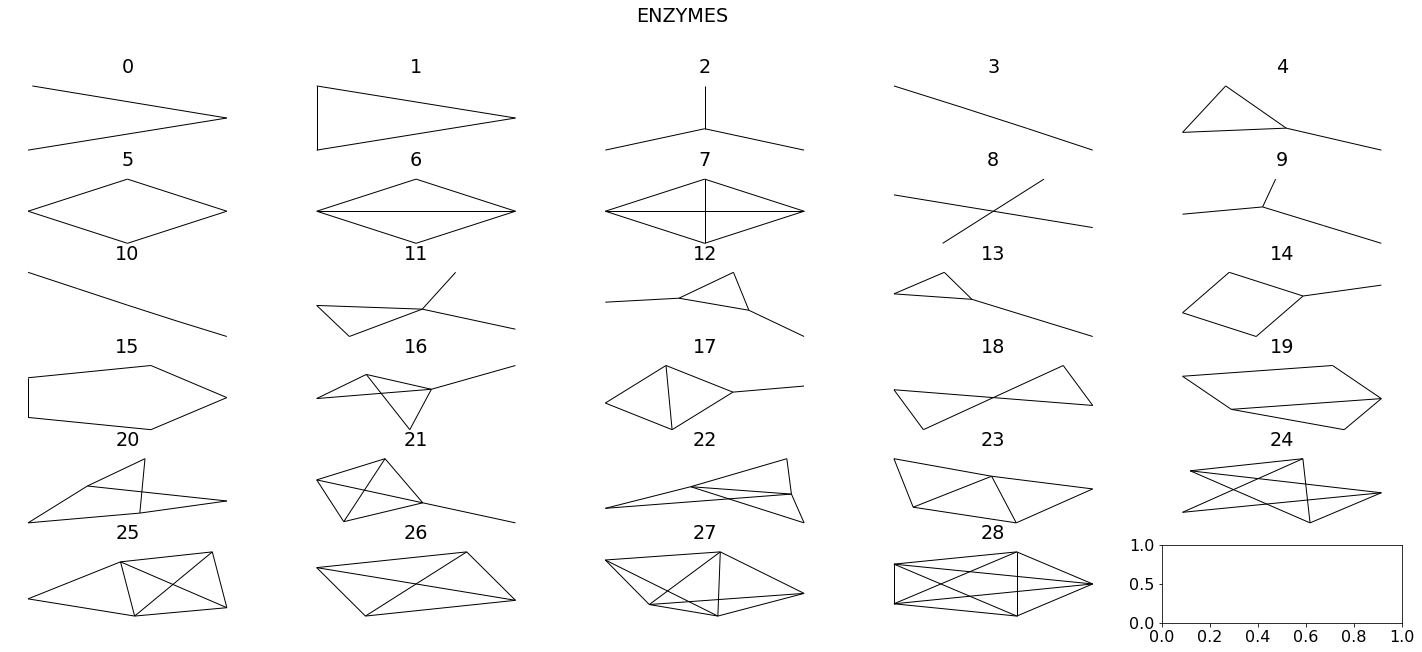

In [24]:
nrows = 6
ncols = math.ceil(num_query/nrows)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,10))
ax = axes.flatten()

queries = workload.queries
for i,graph in enumerate(queries):
    node_color = [ 'red' if anchor==1 else 'blue' for anchor in nx.get_node_attributes(graph, 'anchor').values() ]
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, ax=ax[i], with_labels=False, pos=pos, node_color=node_color)
    ax[i].title.set_text(str(i))
plt.suptitle(str(args.dataset_name))
plt.show()

draw with query id

In [16]:
query_id

NameError: name 'query_id' is not defined

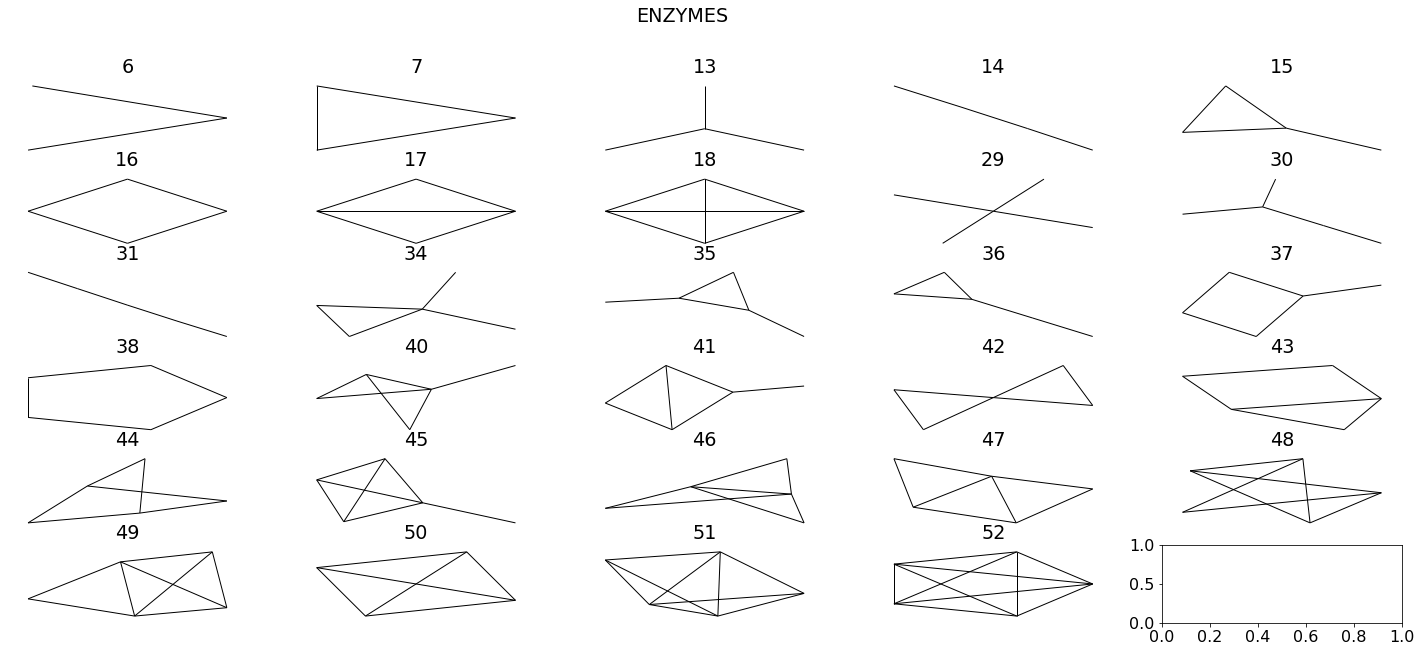

In [18]:
nrows = 6
ncols = math.ceil(num_query/nrows)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,10))
ax = axes.flatten()

# queries = workload.queries
for i,(id,graph) in enumerate(zip(query_ids,queries)):
    node_color = [ 'red' if anchor==1 else 'blue' for anchor in nx.get_node_attributes(graph, 'anchor').values() ]
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, ax=ax[i], with_labels=False, pos=pos, node_color=node_color)
    ax[i].title.set_text(str(id))
plt.suptitle(str(args.dataset_name))
plt.show()

Visualize data distribution

No handles with labels found to put in legend.


Text(0.5, 0.98, 'pred label')

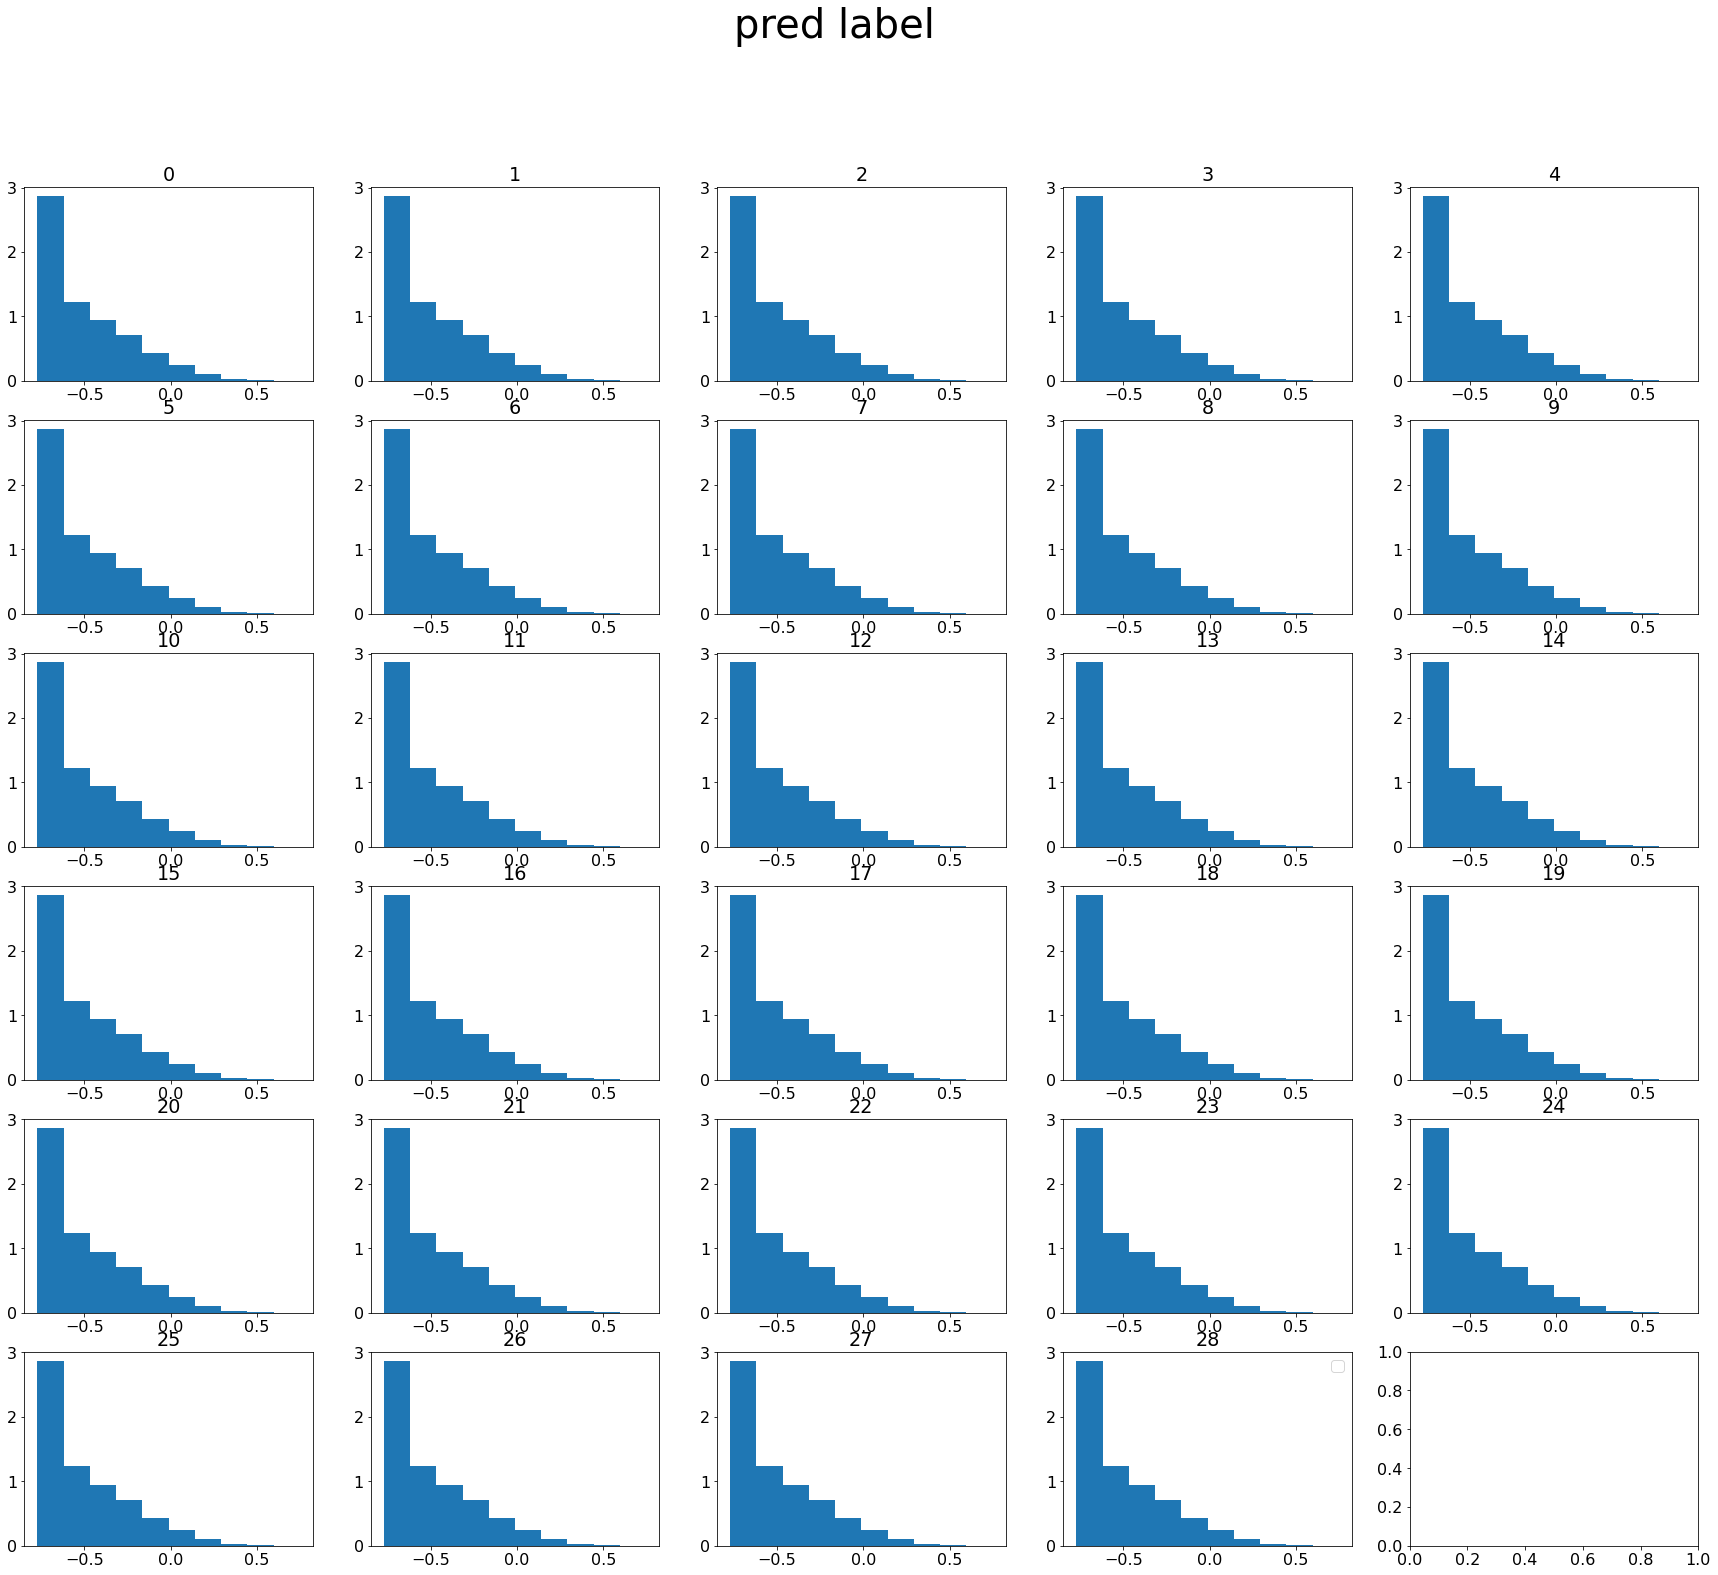

In [25]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,25))
axes = axes.flatten()

for i in range(len(queries)):
# for i in [0,1,2,3,4,5]:
    ax = axes[i]
    ax.hist(count_all[i][:].cpu().numpy().reshape(-1), density= True, rwidth=1)
    ax.set_title(str(i))

ax.legend()
fig.suptitle("pred label", size=40)

No handles with labels found to put in legend.


Text(0.5, 0.98, 'log2(count)')

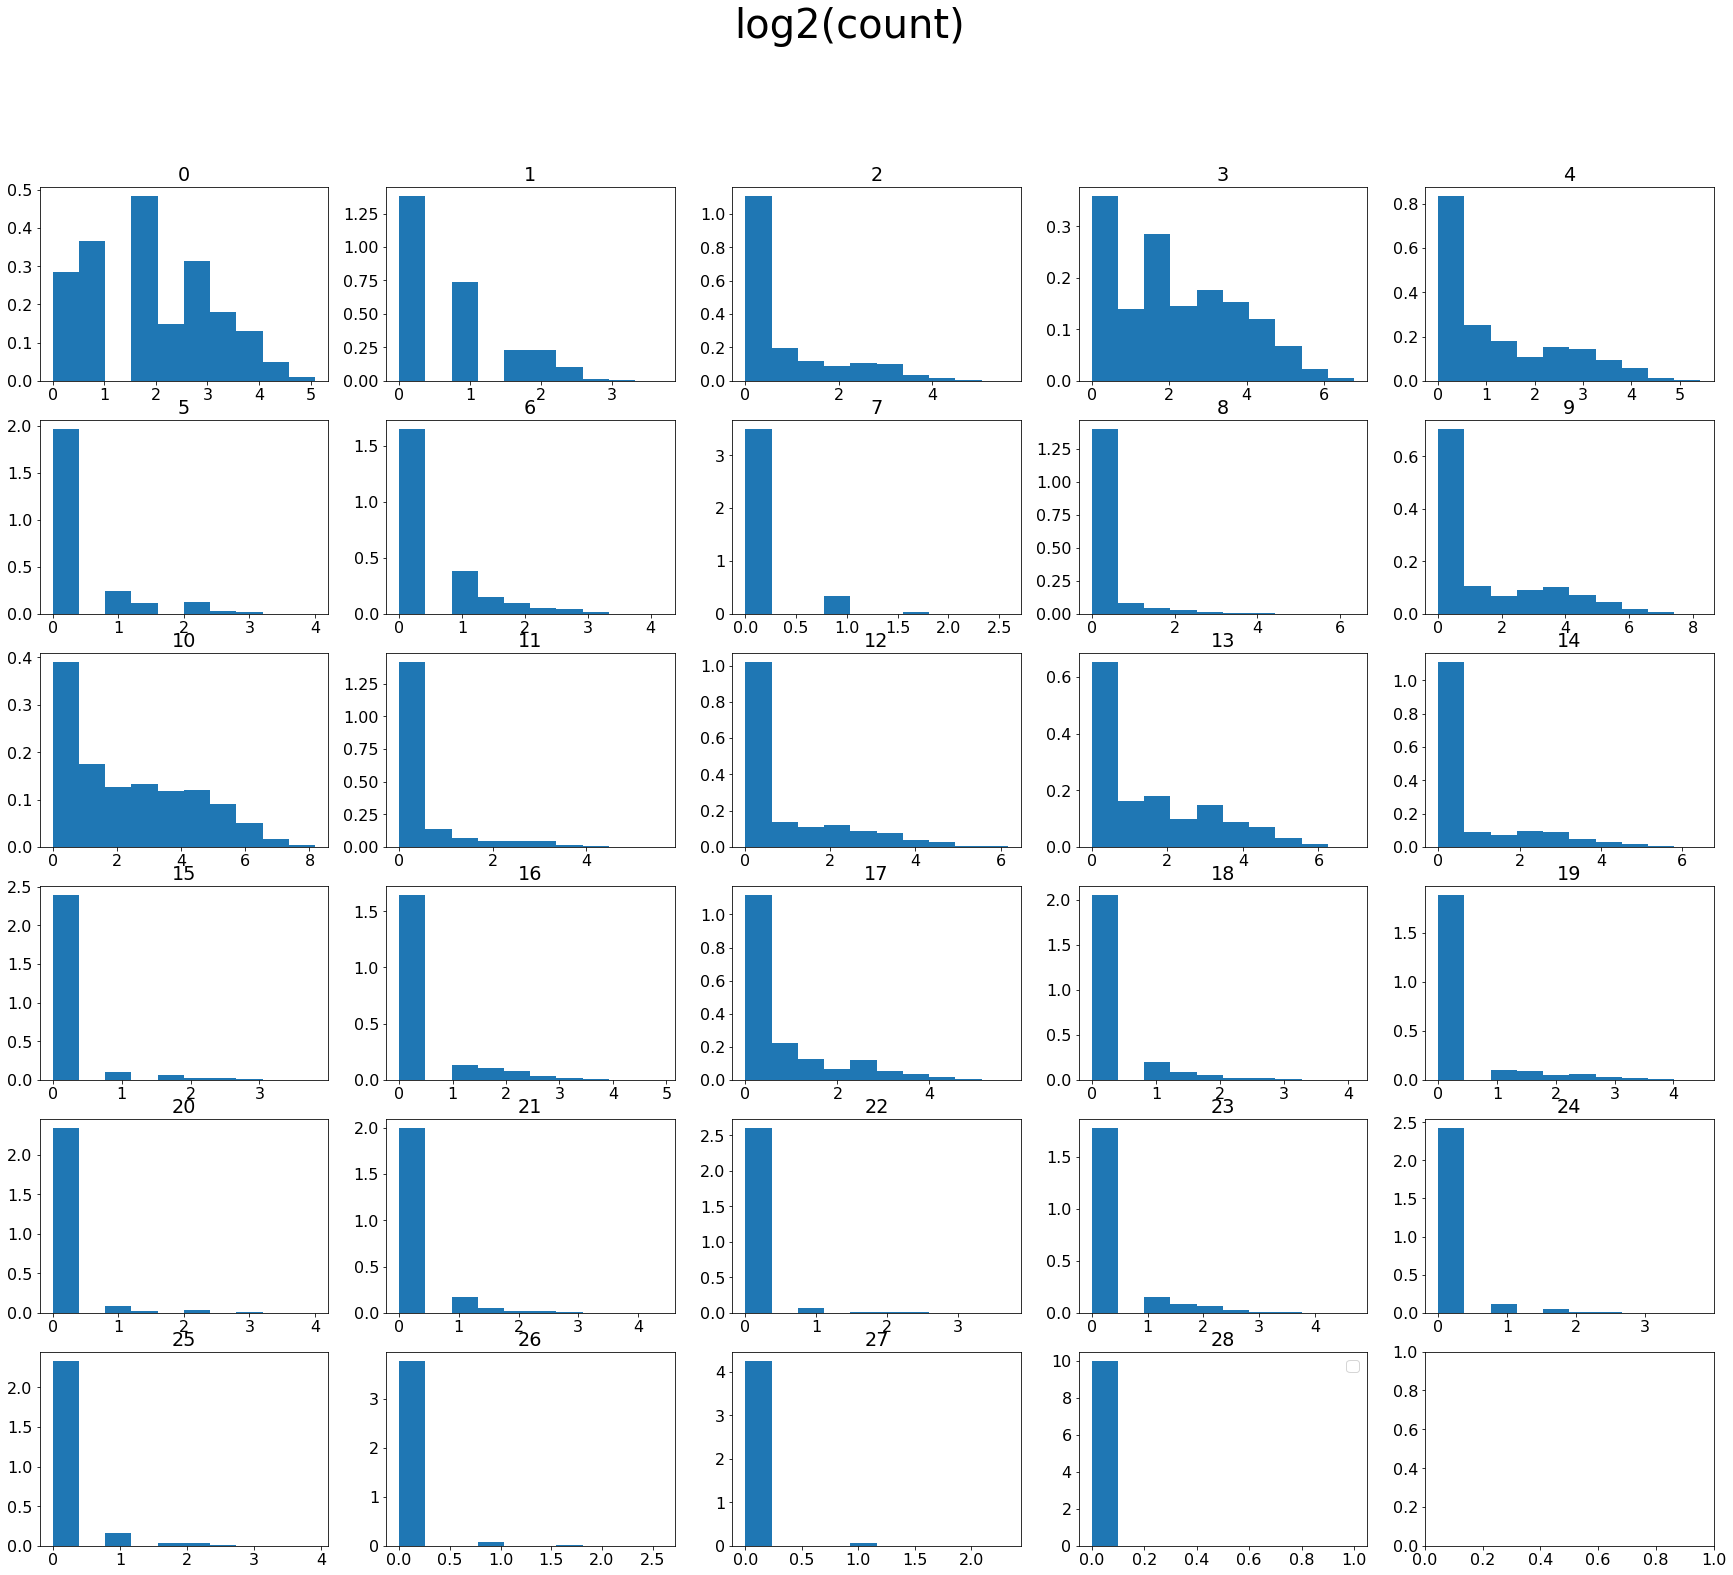

In [26]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30,25))
axes = axes.flatten()

for i in range(len(queries)):
# for i in [0,1,2,3,4,5]:
    ax = axes[i]
    ax.hist(count_motif_all[i][:].cpu().numpy().reshape(-1), density= True, rwidth=1)
    ax.set_title(str(i))

ax.legend()
fig.suptitle("log2(count)", size=40)

convert error to numpy

In [27]:
error_label_np = error_label.cpu().numpy()
error_count_np = error_count.cpu().numpy()

truth_count_np = count_truth.view(count_truth.shape[0],-1).cpu().numpy()
model_count_np = count_inference.view(count_inference.shape[0],-1).cpu().numpy()

truth_label_np = label_truth.view(label_truth.shape[0],-1).cpu().numpy()
model_label_np = label_all.view(label_all.shape[0],-1).cpu().numpy()

draw error of each query

Text(0.5, 1.0, 'pred label')

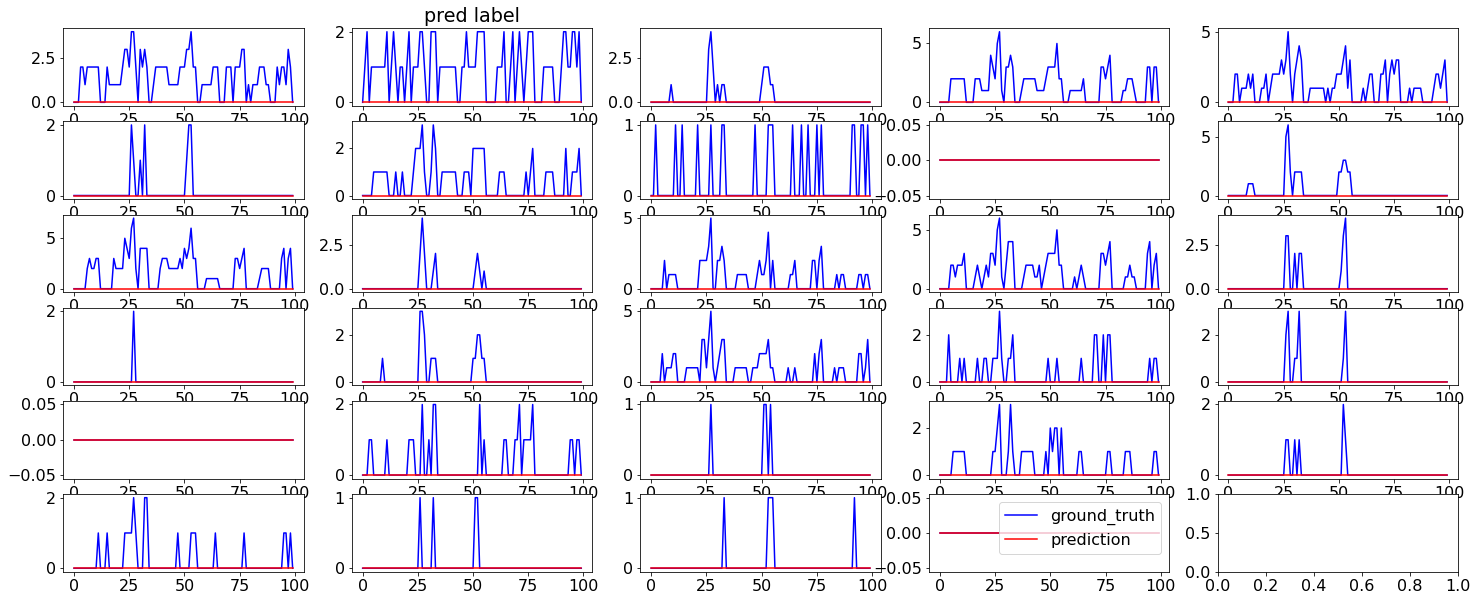

In [28]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,10))
axes = axes.flatten()
for i in range(len(queries)):
# for i in [0,1,2,3,4,5]:
    ax = axes[i]
    ax.plot(truth_label_np[i][0:100], color='blue', label='ground_truth')
    ax.plot(model_label_np[i][0:100], color='red', label='prediction')

ax.legend()
axes[1].set_title("pred label")

Text(0.5, 1.0, 'pred count')

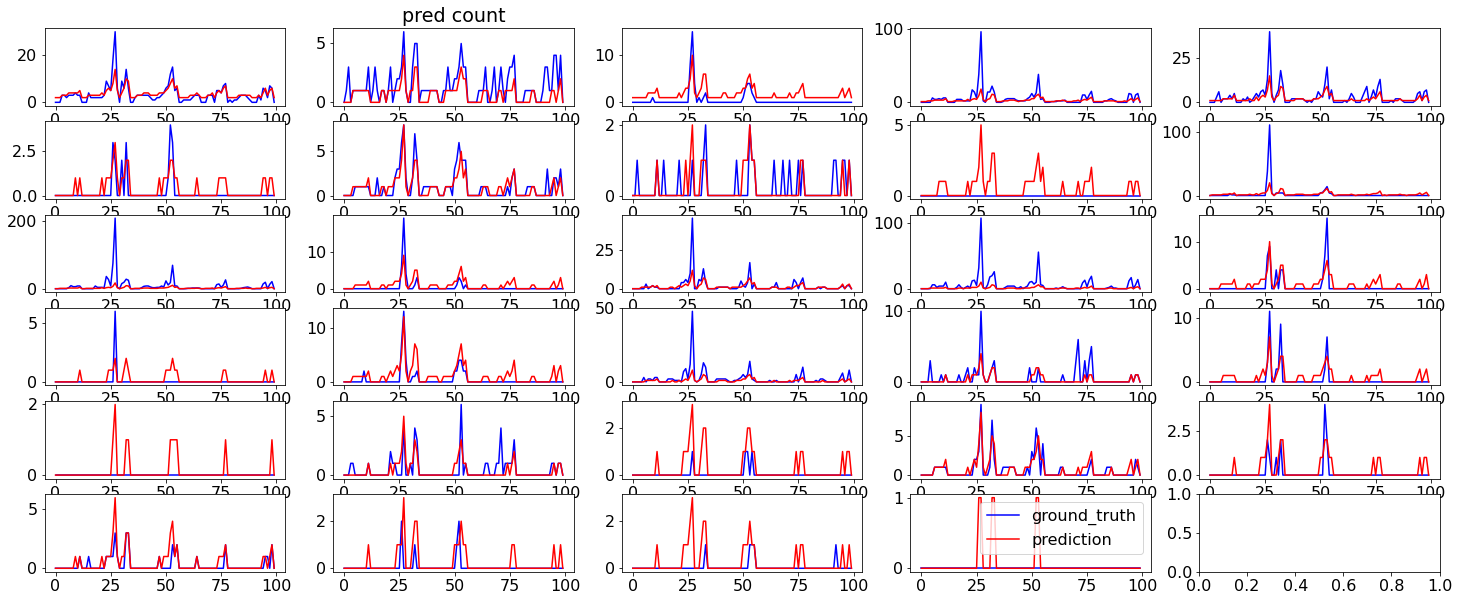

In [29]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,10))
axes = axes.flatten()
for i in range(len(queries)):
    ax = axes[i]
    ax.plot(truth_count_np[i][0:100], color='blue', label='ground_truth')
    ax.plot(model_count_np[i][0:100], color='red', label='prediction')

ax.legend()
axes[1].set_title("pred count")

visualize dataset

Text(0.5, 0.98, 'ENZYMES')

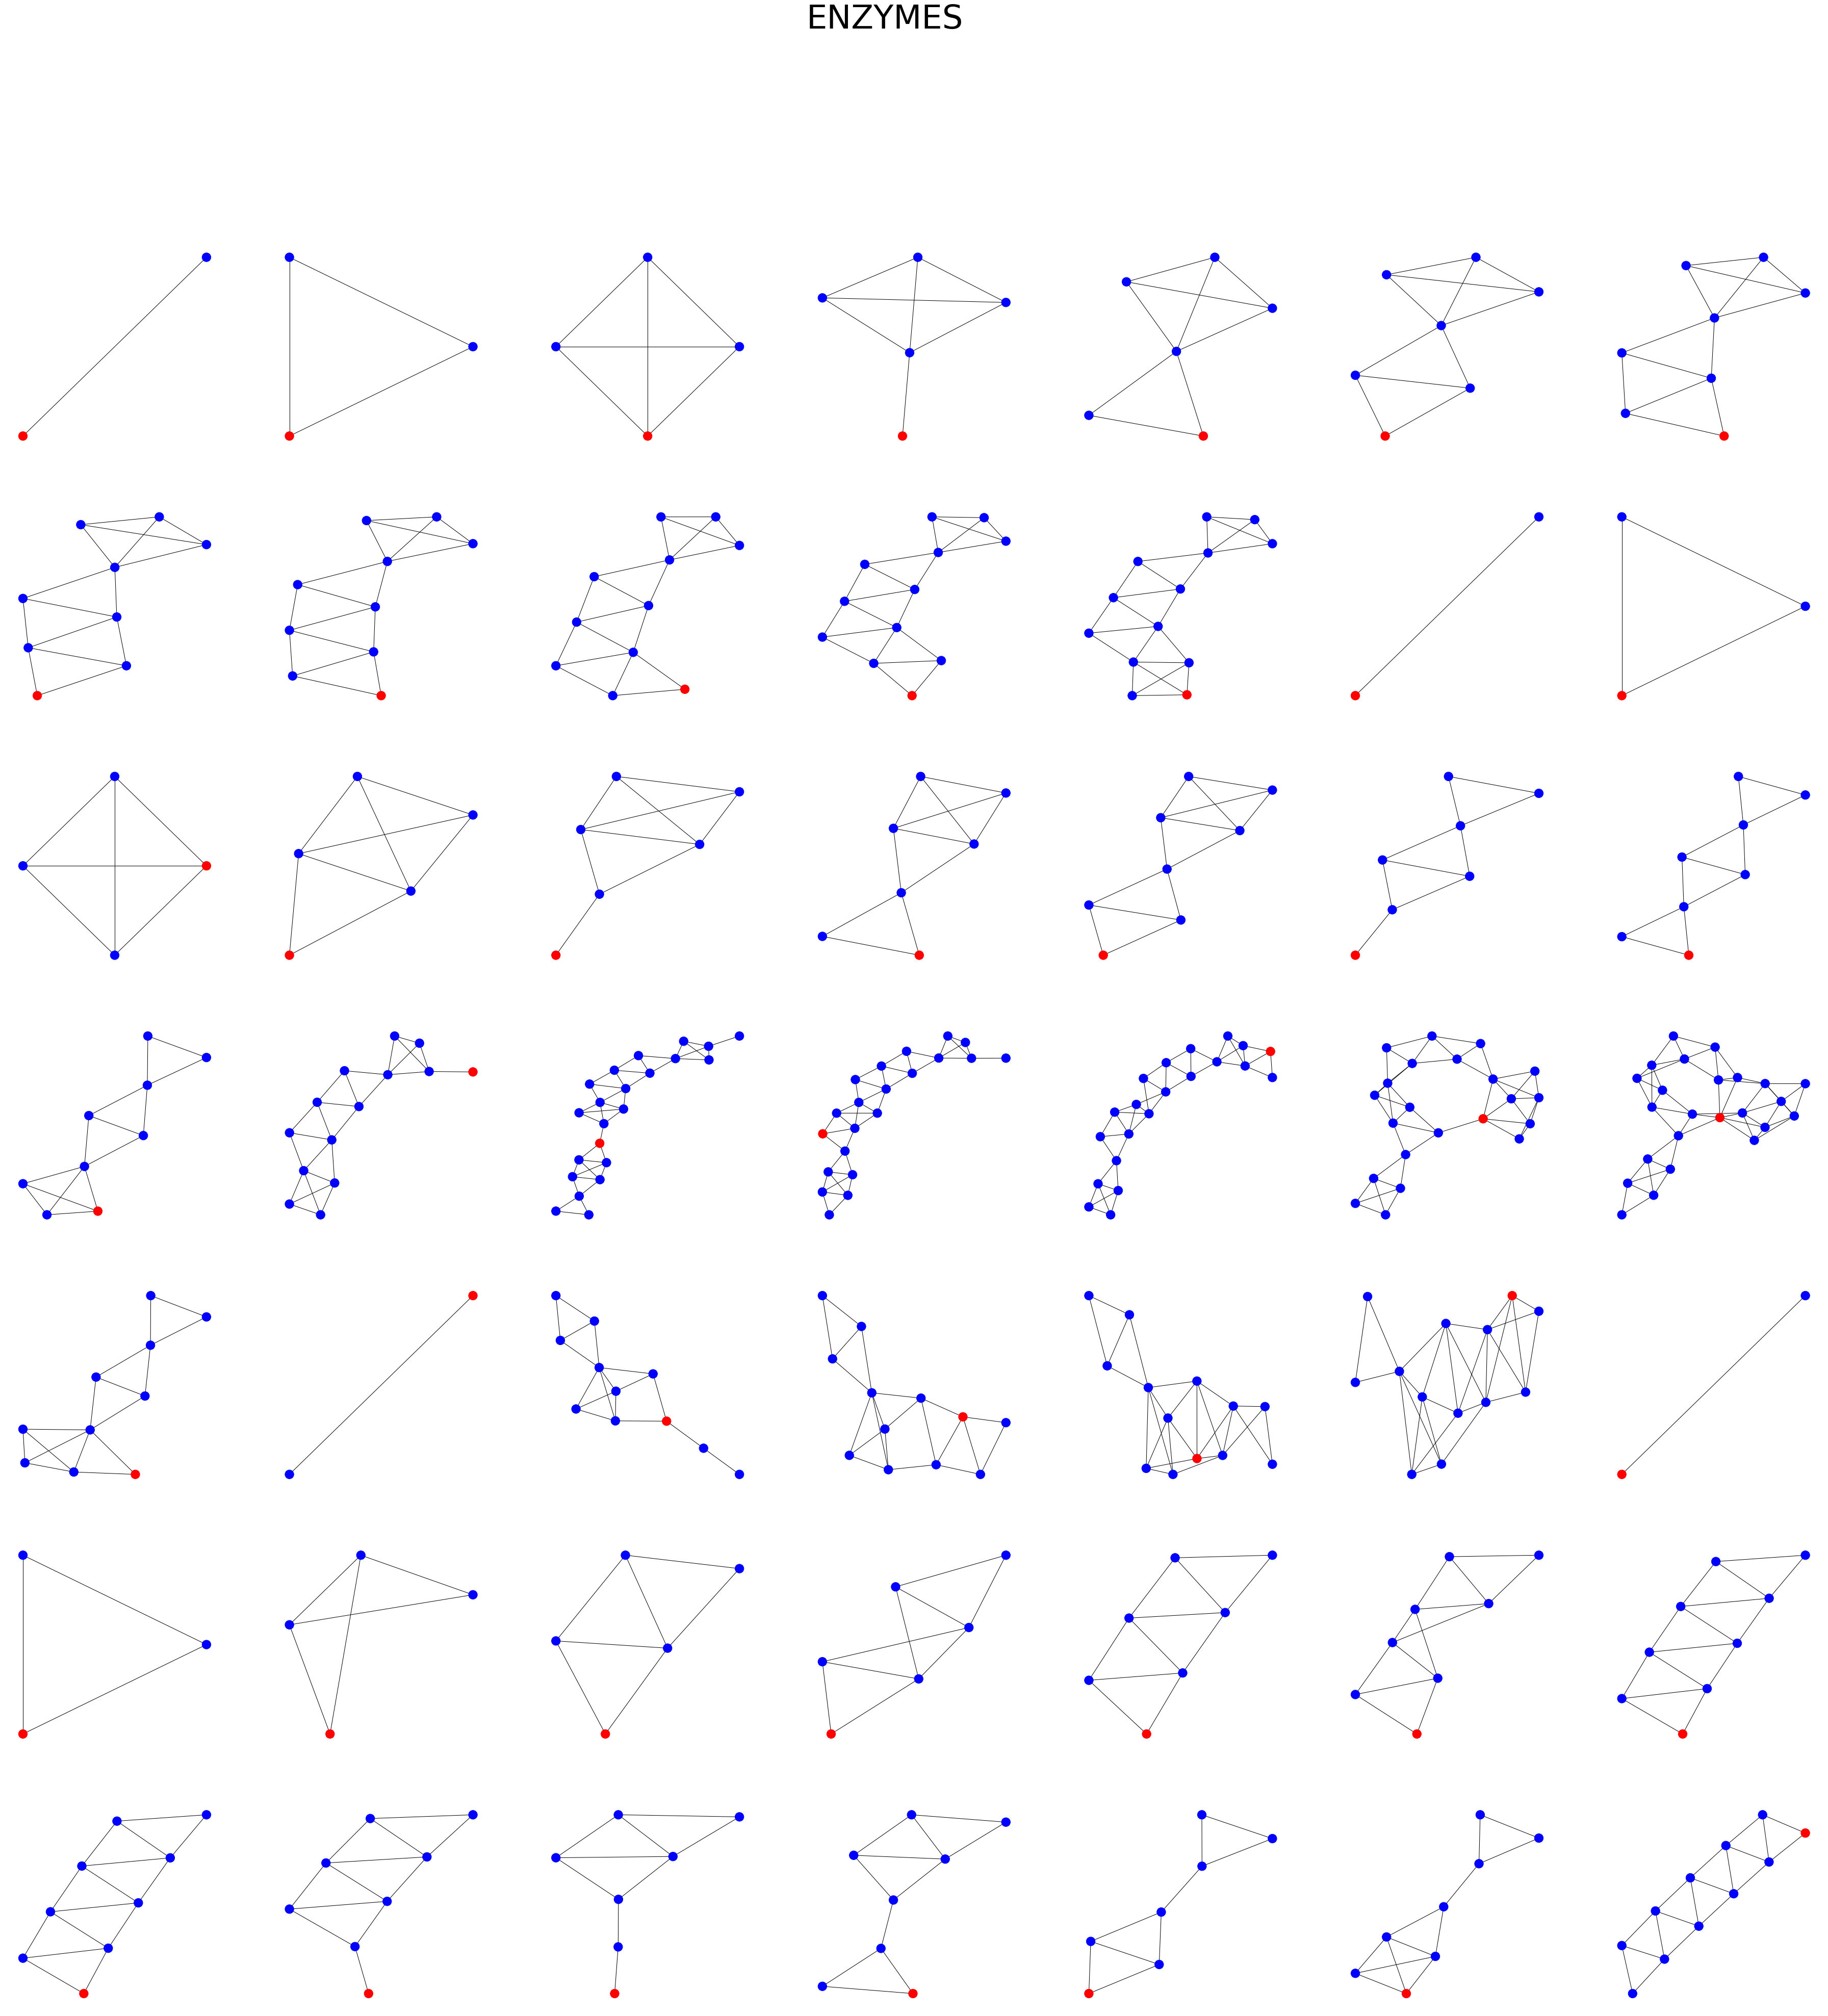

In [30]:
fig_limit = 49

fig, axes = plt.subplots(nrows=math.ceil(math.sqrt(fig_limit)), ncols=math.ceil(math.sqrt(fig_limit)), figsize=(64,64))
axes = axes.flatten()
i = 0
stop = False
for batch in neighs_batch_all:
    for g in batch.G:
        # print(g)
        ax = axes[i]
        node_color = ['blue' if g.nodes[n]['node_feature'].cpu().item()==0 else 'red' for n in g.nodes]
        nx.draw(g, pos = nx.kamada_kawai_layout(g), ax=ax, with_labels= False, node_color= node_color)
        i += 1
        if i >= fig_limit:
            stop = True
            break
    if stop:
        break

plt.suptitle(str(args.dataset_name), fontsize=64)

tests

In [31]:
# graph = query
# colors = ["red" if graph.nodes[node]['anchor']==1 else "blue" for node in graph.nodes()]
# pos = nx.kamada_kawai_layout(graph)
# nx.draw(graph, with_labels=True, node_color=colors, pos=pos)